In [1]:
import os
import pathlib
import sys

default_dir_path = str(pathlib.Path(os.getcwd()).parent.absolute())

sys.path.append(default_dir_path)

from properties import *

d:\programming\python\venv\myunghwa-ai-vision-inspection-practice\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
[2021-01-07 01:01:40,619][INFO][properties.py:30] Complete to apply the random seed, RANDOM_SEED : 777


In [2]:
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from model.model_set import ModelSet
from dataset.generator.crop_data_generator import CropDataGenerator
from dataset.dataset import EOPTrainingDataset
from domain.hyperparameters import Hyperparameters
from trainer.ae_trainer import AutoencoderTrainer
from model.ae_custom import AutoencoderModelCustom01


LABEL_PATH = DATASET_PROPERTIES.LABEL_PATH

HOUSING_NG_PATH = DATASET_PROPERTIES.HOUSING_NG_PATH
HOUSING_OK_PATH = DATASET_PROPERTIES.HOUSING_OK_PATH

COVER_NG_PATH = DATASET_PROPERTIES.COVER_NG_PATH
COVER_OK_PATH = DATASET_PROPERTIES.COVER_OK_PATH

## Load DatasetGenerator

In [3]:
device = MODEL_PROPERTIES.DEVICE_CPU
crop_part= "grid_1"

In [4]:
model_set = ModelSet.housing_cam2_autoencoder_model_set_1()

## Crop Grid Test

In [5]:
# Ori : (90, 367)
model_metadata = model_set.models[crop_part]
image_metadata = model_metadata.image_metadata
model_file_metadata = model_metadata.model_file_metadata

# cropping_properties = get_cropping_properties(model_data=model_data)
train_img_path_list, test_img_path_list = CropDataGenerator.get_anomaly_data_with_image_metadata(
    image_metadata=image_metadata,
    is_loaded=True,
    is_train_entire=False
)

print(f"Train dataset size : {len(train_img_path_list)}, Test dataset size : {len(test_img_path_list)}")

Train dataset size : 4, Test dataset size : 2


In [6]:
normalization_variables_file_path = model_file_metadata.get_normalization_variables_file_path()
normalization_variables_file_path

'D:\\AI_Lab\\MH\\git\\newnewnew\\Myunghwa-AI-Vision-Inspection-Practice\\model\\results\\housing_2_grid_1_autoencoder_256\\normalization_variables.json'

In [7]:
train_dataset = EOPTrainingDataset(
    img_path_list=train_img_path_list,
    normalization_variables_file_path=normalization_variables_file_path,
    normalization_variables="save",
    resize_rate=0.5,
    transform=None
)

print(f"Train dataset normalization variables : {train_dataset.normalization_variables}")

test_dataset = EOPTrainingDataset(
    img_path_list=test_img_path_list,
    normalization_variables_file_path=normalization_variables_file_path,
    normalization_variables="load",
    resize_rate=0.5,
    transform=None
)

print(f"Test dataset normalization variables : {test_dataset.normalization_variables}")

Train dataset normalization variables : ((85.12483596801758,), (28.374389171600342,))
Normalization variables loaded : ((85.12483596801758,), (28.374389171600342,))
Test dataset normalization variables : ((85.12483596801758,), (28.374389171600342,))


In [8]:
print(train_dataset.transform)
print(test_dataset.transform)

Compose(
    ToTensor()
    Normalize(mean=(85.12483596801758,), std=(28.374389171600342,))
)
Compose(
    ToTensor()
    Normalize(mean=(85.12483596801758,), std=(28.374389171600342,))
)


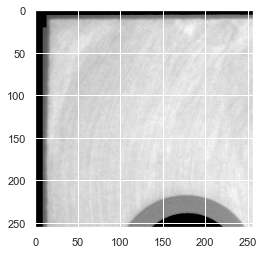

In [9]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[0][0].squeeze().numpy(), cmap='gray')
plt.show()

In [10]:
train_dataset[0][0].squeeze().numpy().shape

(256, 256)

In [11]:
# train_sample_weights = get_sample_weights(dataset=train_dataset)

# Create data loader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
#     sampler=WeightedRandomSampler(train_sample_weights, len(train_dataset))
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False
)

In [12]:
model = AutoencoderModelCustom01()

In [13]:
model.to(device)

AutoencoderModelCustom01(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(32, 32), stride=(16, 16), padding=(8, 8))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 32, kernel_size=(32, 32), stride=(16, 16), padding=(8, 8))
    (3): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(32, 32), stride=(16, 16), padding=(8, 8))
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConvTranspose2d(32, 1, kernel_size=(32, 32), stride=(16, 16), padding=(8, 8))
    (3): LeakyReLU(negative_slope=0.2)
  )
)

In [14]:
ae_trainer = AutoencoderTrainer(
    model=model,
    model_file_metadata=model_file_metadata,
    train_loader=train_loader,
    val_loader=test_loader,
    test_loader=test_loader,
    hyperparameters=Hyperparameters(
        optimizer_cls=optim.Adam,
        lr=1e-3,
        weight_decay=0,
        n_epoch=1000,
        early_stopping_patience=10,  # default 75
        criterion=F.mse_loss,
        device=device,
        is_saved=True,
        checkpoint_period=20
    ),
    tqdm_env='script'
)

[2021-01-07 01:01:47,448][INFO][base.py:41] Model set to 'cpu'


 29%|██▉       | 294/1000 [00:50<02:01,  5.82it/s]
[2021-01-07 01:02:38,653][DEBUG][ae_trainer.py:195] Success to save model


[ Epoch 0 ]
Train Loss : 0.9760443
Validation Loss : 1.0315909
Early Stopping Count : 1, Best Validation Loss : 1.0315909385681152
Save checkpoint - epoch : 0
[ Epoch 1 ]
Train Loss : 0.9728583
Validation Loss : 1.0055625
Early Stopping Count : 0, Best Validation Loss : 1.0055625438690186
[ Epoch 2 ]
Train Loss : 0.9544362
Validation Loss : 0.9764866
Early Stopping Count : 0, Best Validation Loss : 0.9764866232872009
[ Epoch 3 ]
Train Loss : 0.9364785
Validation Loss : 0.9497731
Early Stopping Count : 0, Best Validation Loss : 0.9497730731964111
[ Epoch 4 ]
Train Loss : 0.9137781
Validation Loss : 0.9315871
Early Stopping Count : 0, Best Validation Loss : 0.9315871000289917
[ Epoch 5 ]
Train Loss : 0.8979585
Validation Loss : 0.9129456
Early Stopping Count : 0, Best Validation Loss : 0.9129456281661987
[ Epoch 6 ]
Train Loss : 0.8833468
Validation Loss : 0.8956715
Early Stopping Count : 0, Best Validation Loss : 0.8956714868545532
[ Epoch 7 ]
Train Loss : 0.8692071
Validation Loss : 0.

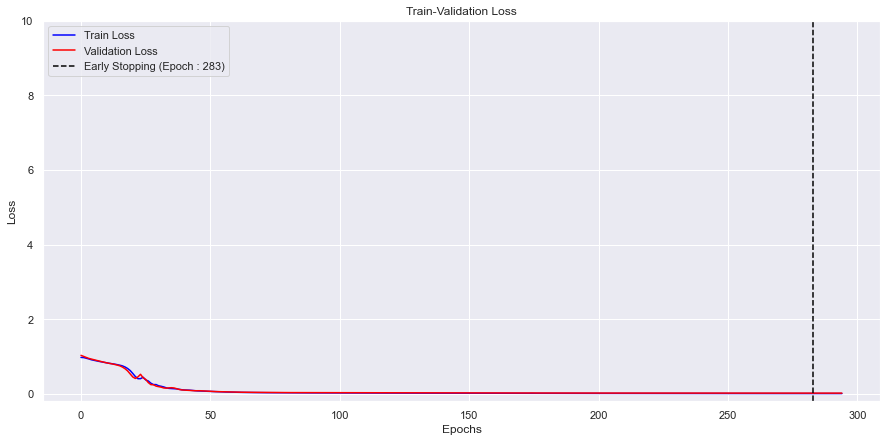

In [15]:
result_dict = ae_trainer.train()